In [1]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

import numpy as np

import torch_geometric
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import radius_graph
from torch_geometric.data import Data

import networkx as nx

import pickle

import time

import sys
import os
from genericpath import exists

import random

model_path = "model.pkl"
loss_path = "loss.pkl"

from cell_dataset import CellGraphDataset
from cell_model import GraphEvolution
from cell_utils import GraphingLoss, make_animation
from cell_training import train, test, run_single, run_single_recursive

import threading
import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
import allium

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using :  298
Available :  3279
True


In [2]:
#path = "data/" #local
path = "/scratch/users/nstillman/data-cpp/" #remote

data_train = CellGraphDataset(root=path + 'train', max_size=200, rdts=True, inmemory=True, bg_load=False)
print("Training data length : ", data_train.len())

data_test = CellGraphDataset(root=path + 'test', max_size=50, inmemory=True, bg_load=False)
print("Test data length : ", data_test.len())
 
data_val = CellGraphDataset(root=path + 'valid', max_size=50, inmemory=True, bg_load=False)
print("Validation data length : ", data_val.len())

Training data length :  200
Test data length :  50
Validation data length :  50


In [3]:
override = True #make this true to always use the same ones

if override :
    data_train.save_or_load_if_exists("train_paths.pkl")
    data_test.save_or_load_if_exists("test_paths.pkl")
    data_val.save_or_load_if_exists("val_paths.pkl")

In [4]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, batch_edge, norm_and_std = data_train.get(0)

In [11]:
model_to_test = "model_530.pkl"
result_name = "result_530_recursive.pkl"

In [12]:
with open(model_to_test, "rb") as f:
    model = pickle.load(f)

model.eval()
loss, out, x = run_single_recursive(model, data_test, 0, "cuda" if torch.cuda.is_available() else "cpu", denormalize=True)
print("shapes : ", out.shape, x.shape) # type: ignore

shapes :  torch.Size([62, 327, 4]) torch.Size([62, 327, 4])


In [13]:
with open(result_name, "wb") as f:
    pickle.dump((out, x), f)

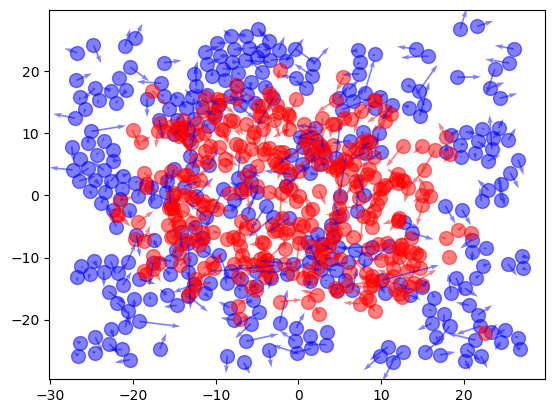

In [14]:
t = 30

pos_out = out[t, :, :2] # type: ignore
pos_x = x[t, :, :2] # type: ignore

speed_out = out[t, :, 2:] # type: ignore
speed_x = x[t, :, 2:] # type: ignore

#now plot the graph as bubbles to show the difference between the two
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=100, c='b', alpha=0.5)
plt.scatter(pos_out[:, 0], pos_out[:, 1], s=100, c='r', alpha=0.5)

#show an arrow for the speed
plt.quiver(pos_x[:, 0], pos_x[:, 1], speed_x[:, 0], speed_x[:, 1], color='b', alpha=0.5)
plt.quiver(pos_out[:, 0], pos_out[:, 1], speed_out[:, 0], speed_out[:, 1], color='r', alpha=0.5)

In [10]:
raise Exception("Need ffmpeg to continue")

Exception: Need ffmpeg to continue

In [3]:
result_name = "./result_archive/transform/result_530_recursive.pkl"
animation_name = "./result_archive/transform/animation_530_recursive.mp4"
make_animation(result_name, animation_name)